# Baixando e importando bibliotecas (não modificar)

In [137]:
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import pandas as pd
from yahooquery import Ticker
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro, jarque_bera
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Fatos Estilizados: TOTVS


**1 - Distribuições não Gaussianas**

Identificando o período dos dados totais disponíveis

In [139]:
ticker = 'TOTS3.SA'
nome = 'TOTVS'
periodo = Ticker(ticker)
periodo.history(period='max').reset_index()['date']

0       2006-03-09
1       2006-03-10
2       2006-03-13
3       2006-03-14
4       2006-03-15
           ...    
4118    2022-10-05
4119    2022-10-06
4120    2022-10-07
4121    2022-10-10
4122    2022-10-11
Name: date, Length: 4123, dtype: object

Selecionando o período e coluna de fechamento dos preços. A coluna de fechamento é renomeada para o nome da empresa escolhida

In [140]:
data_inicial = '2006-03-09'
data_final = '2022-10-11'
acao = periodo.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
acao

,TOTVS
date,
2006-03-09,2.262368
2006-03-10,2.328908
2006-03-13,2.355524
2006-03-14,2.362178
2006-03-15,2.395448
...,...
2022-10-04,31.129999
2022-10-05,31.309999
2022-10-06,31.160000


Calculando a função de densidade de probabilidade normal utilizando a média e o desvio padrão dos retornos observados

In [141]:
retornos = acao.pct_change().dropna()
r_range = np.linspace(retornos.min(), retornos.max(), num=1000)
mu = retornos.mean()
sigma = retornos.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Plotando o histograma e o Q-Q plot

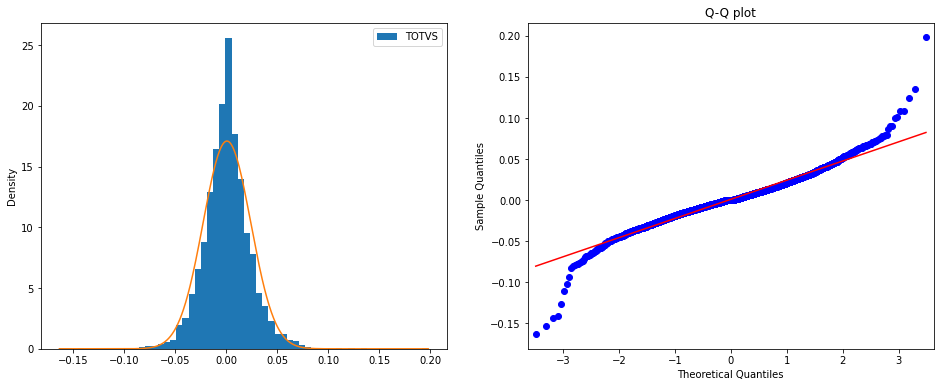

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histograma comparando com uma distribuição normal de mesma média e desvio padrão:
retornos.plot.hist(density=True, bins=60, ax=ax[0], ylabel='Density');
# parâmetros para curva normal
mediaR = retornos.mean()
desvpadR = retornos.std()
minR = retornos.min()
maxR = retornos.max()
x = np.linspace(minR,maxR,1000)
ax[0].plot(x, scs.norm.pdf(x,loc=mediaR,scale=desvpadR))
ax[0].set(ylabel='Density')

# Q-Q plot
qq = sm.qqplot(retornos[nome].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 12)
plt.show()

Teste quantitativo de normalidade de Shapiro-Wilk

In [143]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
shapirowilk = shapiro(retornos)
if shapirowilk[1] <= 0.05:
  print("Hipotese Nula Rejeitada")
else:
  print("Não rejeitar hipotese nula") #minha amostra possui uma distribuição normal

print('O valor-p calculado foi de', shapirowilk[1])

Hipotese Nula Rejeitada
O valor-p calculado foi de 2.240326487963814e-31


Teste quantitativo de normalidade de Jarque-Bera

In [144]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
jarque_bera(retornos)

Jarque_beraResult(statistic=3506.7320033170827, pvalue=0.0)

In [145]:
len(retornos)

4121

In [146]:
# Jarque-Bera implementado "na unha"
JB = (len(retornos)/6)*( skew(retornos)**2 + (1/4)*(kurtosis(retornos)**2 ))
JB

array([3506.73200332])

Comparando o teste com dados normalmente distribuídos

In [147]:
norm = np.random.randn(len(retornos))
jarque_bera(norm)

Jarque_beraResult(statistic=2.080182868738564, pvalue=0.35342236553030415)

**2 - Aglomerados de volatilidade**

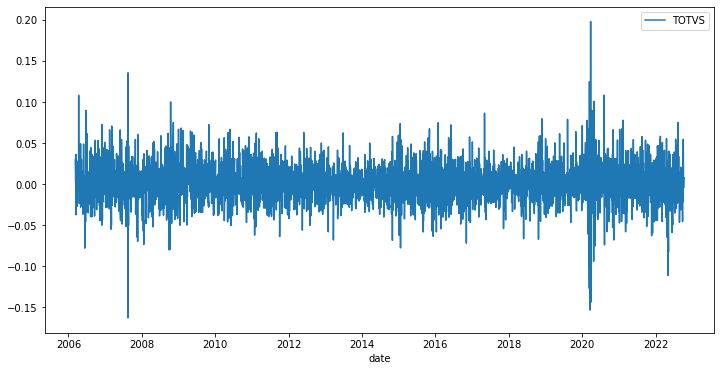

In [148]:
retornos.plot(figsize=(12,6));

**3 - Ausência de autocorrelação**

Autocorrelação dos retornos diários

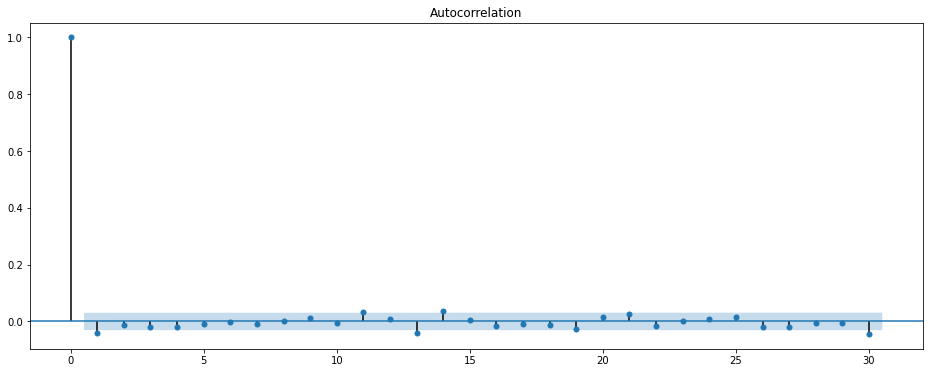

In [149]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos,lags=30, ax=ax)
plt.show()

Retornos em 1 min

In [150]:
acao1m = periodo.history(period='7d',  interval = '1m')
acao1m = acao1m.rename({"close": nome}, axis=1).xs(ticker)
acao1m = acao1m[[nome]]
acao1m

,TOTVS
date,
2022-10-03 10:09:00,30.100000
2022-10-03 10:10:00,30.139999
2022-10-03 10:11:00,30.080000
2022-10-03 10:12:00,30.100000
2022-10-03 10:13:00,30.160000
...,...
2022-10-11 16:51:00,30.129999
2022-10-11 16:52:00,30.139999
2022-10-11 16:53:00,30.170000


Autocorrelação dos retornos em 1 min

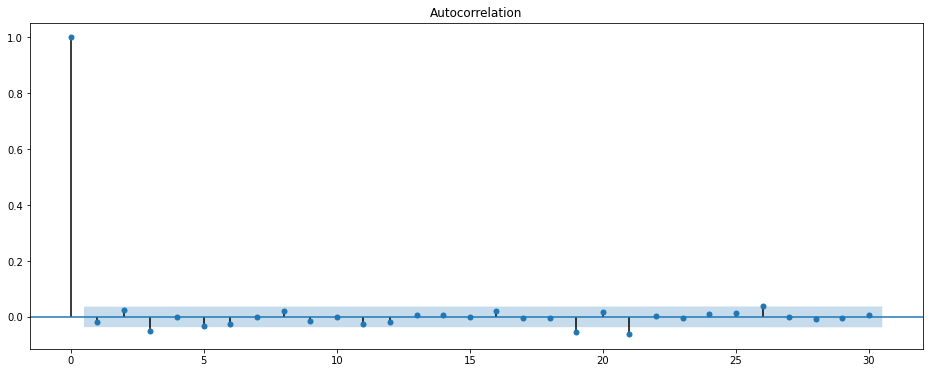

In [151]:
fig, ax = plt.subplots(figsize=(16, 6))
retornos1m = acao1m.pct_change().dropna()
plot_acf(retornos1m,lags=30, ax=ax)
plt.show()

**4 - Decaimento lento da autocorrelação dos quadrados dos retornos**

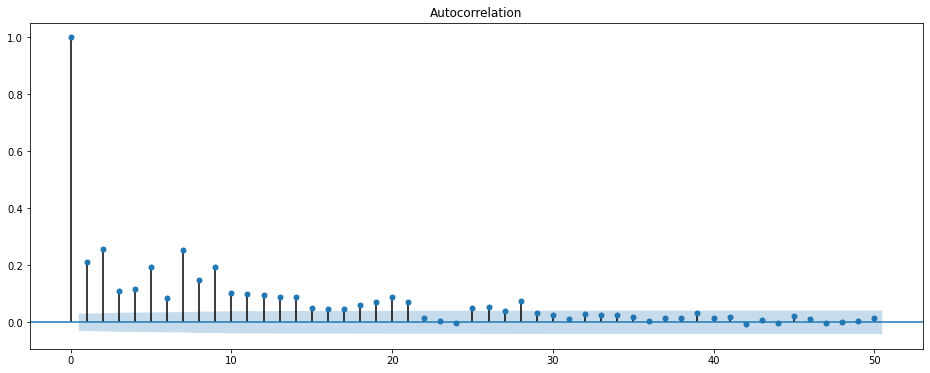

In [152]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos**2,lags=50, alpha=0.05, ax=ax)
plt.show()

É válido também para o módulo dos retornos

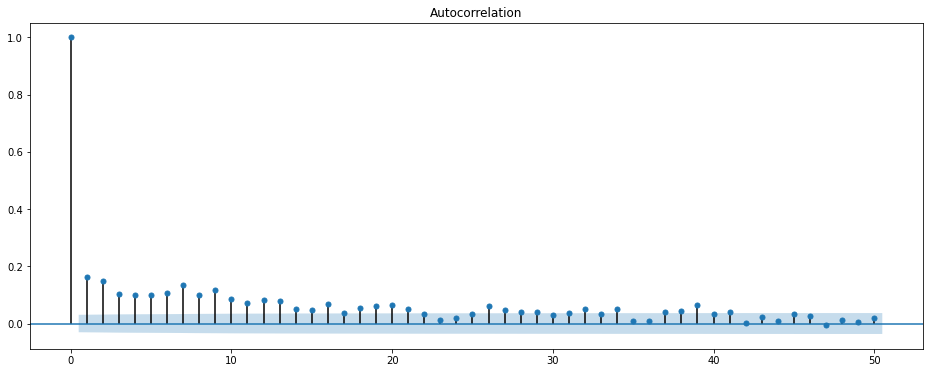

In [153]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(abs(retornos),lags=50, alpha=0.05, ax=ax)
plt.show()

**5 - Efeito de alavancagem**

In [154]:
desv_pad_21d = retornos[nome].rolling(window=21).std()
desv_pad_21d

date
2006-03-10         NaN
2006-03-13         NaN
2006-03-14         NaN
2006-03-15         NaN
2006-03-16         NaN
                ...   
2022-10-04    0.021737
2022-10-05    0.021742
2022-10-06    0.020332
2022-10-07    0.020026
2022-10-10    0.019814
Name: TOTVS, Length: 4121, dtype: float64

In [155]:
desv_pad_252d = retornos[nome].rolling(window=252).std()

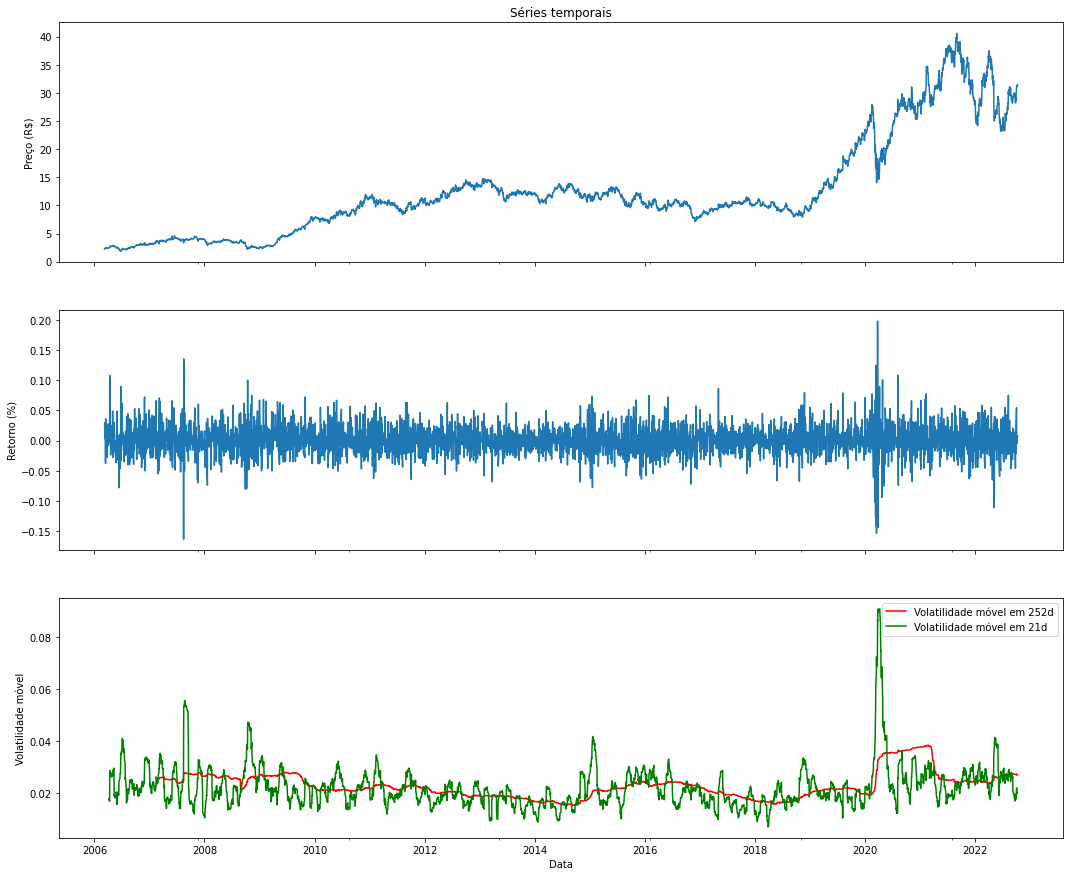

In [156]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
acao[nome].plot(ax=ax[0])
ax[0].set(title='Séries temporais', ylabel='Preço (R$)')
retornos[nome].plot(ax=ax[1])
ax[1].set(ylabel='Retorno (%)')
desv_pad_252d.plot(ax=ax[2], color='r', label='Volatilidade móvel em 252d')
desv_pad_21d.plot(ax=ax[2], color='g', label='Volatilidade móvel em 21d')
ax[2].set(ylabel='Volatilidade móvel', xlabel='Data')
ax[2].legend()
plt.show()

**6 - Gaussianidade agregativa**

In [157]:
# Dataframe com colunas de retornos com lags para serem utilizados no loop
df_retornos_lag = pd.DataFrame(acao[nome])
lags = 6
for lag in range(1, lags+1):
    col = f'Retorno com lag de {lag} dias'
    df_retornos_lag[col] = df_retornos_lag[nome]. \
                         pct_change(periods=lag)
    
df_retornos_lag.replace([np.inf, -np.inf], np.nan, inplace=True)
df_retornos_lag.dropna(inplace=True)
df_retornos_lag.head()

,TOTVS,Retorno com lag de 1 dias,Retorno com lag de 2 dias,Retorno com lag de 3 dias,Retorno com lag de 4 dias,Retorno com lag de 5 dias,Retorno com lag de 6 dias
date,,,,,,,
2006-03-17,2.388794,0.036075,-0.002778,0.011268,0.014124,0.025714,0.055882
2006-03-20,2.409422,0.008635,0.045022,0.005834,0.020000,0.022881,0.034572
2006-03-21,2.448680,0.016294,0.025070,0.062049,0.022222,0.036620,0.039548
2006-03-22,2.455334,0.002717,0.019055,0.027855,0.064935,0.025000,0.039436
2006-03-23,2.448680,-0.002710,0.000000,0.016294,0.025070,0.062049,0.022222


In [158]:
# Extraindo a estatística descritiva de cada coluna utilizando a função describe() do pandas
def extract_data_stats(df_col):
    d_stat = df_col.describe()
    mu = d_stat['mean']
    sigma = d_stat['std']
    rtn_range = np.linspace(d_stat['min'], d_stat['max'], num=1000)
    norm_pdf = scs.norm.pdf(rtn_range, loc=mu, scale=sigma)
    
    return mu, sigma, rtn_range, norm_pdf

# Usa o ax para criar múltiplos gráficos
def draw_hist_mult(df_col, ax=None):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(df_col)
    #sns.distplot(df_col, kde=True, norm_hist=True, label='Hist', ax=ax)
    sns.histplot(df_col, kde=True, stat="density", label='Hist', ax=ax, alpha=.3)
    ax.plot(rtn_range, norm_pdf, 'r', lw=3)
    ax.axvline(x=0, c='c',linestyle='--', lw=3)
    ax.set_xlim((-4*sigma, 4*sigma))
    ax.legend(loc='upper right', fontsize=8, frameon=True,fancybox=True);

# Cria uma figura com os subplots criados pela função draw_hist_mult()
def draw_hist_subplots(df):
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
  fig.subplots_adjust(hspace = .5) #wspace=.001
  fig.suptitle('Distribuição dos retornos em escalas de tempo crescentes', fontsize=18)
  axs = axs.ravel()
  for i in range(len(df.columns)-1):
    draw_hist_mult(df[df.columns[i+1]], ax = axs[i])

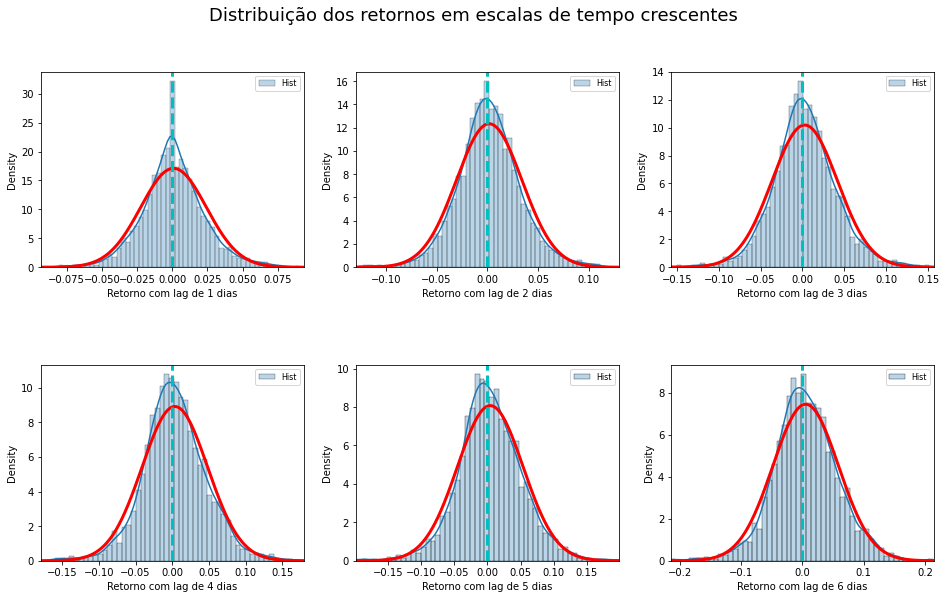

In [159]:
draw_hist_subplots(df_retornos_lag)

É possível verificar que a medida que o intervalo de tempo de cálculo dos retornos aumenta, a distribuição dos retornos tende a uma distribuição normal

## Fatos Estilizados: WEG


**1 - Distribuições não Gaussianas**

Identificando o período dos dados totais disponíveis

In [160]:
ticker = 'WEGE3.SA'
nome = 'WEG'
periodo = Ticker(ticker)
periodo.history(period='max').reset_index()['date']

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
5719    2022-10-05
5720    2022-10-06
5721    2022-10-07
5722    2022-10-10
5723    2022-10-11
Name: date, Length: 5724, dtype: object

Selecionando o período e coluna de fechamento dos preços. A coluna de fechamento é renomeada para o nome da empresa escolhida

In [161]:
data_inicial = '2000-01-03'
data_final = '2022-10-11'
acao = periodo.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
acao

,WEG
date,
2000-01-03,0.168639
2000-01-04,0.162721
2000-01-05,0.162721
2000-01-06,0.147928
2000-01-07,0.147928
...,...
2022-10-04,33.240002
2022-10-05,33.669998
2022-10-06,33.730000


Calculando a função de densidade de probabilidade normal utilizando a média e o desvio padrão dos retornos observados

In [162]:
retornos = acao.pct_change().dropna()
r_range = np.linspace(retornos.min(), retornos.max(), num=1000)
mu = retornos.mean()
sigma = retornos.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Plotando o histograma e o Q-Q plot

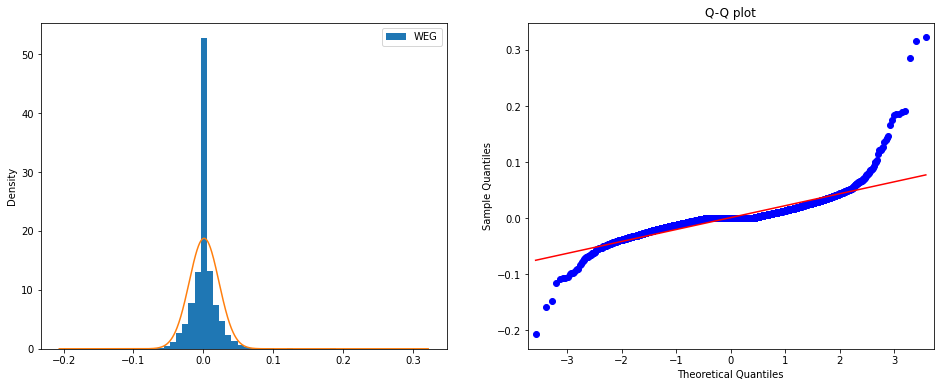

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histograma comparando com uma distribuição normal de mesma média e desvio padrão:
retornos.plot.hist(density=True, bins=60, ax=ax[0], ylabel='Density');
# parâmetros para curva normal
mediaR = retornos.mean()
desvpadR = retornos.std()
minR = retornos.min()
maxR = retornos.max()
x = np.linspace(minR,maxR,1000)
ax[0].plot(x, scs.norm.pdf(x,loc=mediaR,scale=desvpadR))
ax[0].set(ylabel='Density')

# Q-Q plot
qq = sm.qqplot(retornos[nome].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 12)
plt.show()

Teste quantitativo de normalidade de Shapiro-Wilk

In [164]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
shapirowilk = shapiro(retornos)
if shapirowilk[1] <= 0.05:
  print("Hipotese Nula Rejeitada")
else:
  print("Não rejeitar hipotese nula") #minha amostra possui uma distribuição normal

print('O valor-p calculado foi de', shapirowilk[1])

Hipotese Nula Rejeitada
O valor-p calculado foi de 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Teste quantitativo de normalidade de Jarque-Bera

In [165]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
jarque_bera(retornos)

Jarque_beraResult(statistic=309623.9905677791, pvalue=0.0)

In [166]:
len(retornos)

5722

In [167]:
# Jarque-Bera implementado "na unha"
JB = (len(retornos)/6)*( skew(retornos)**2 + (1/4)*(kurtosis(retornos)**2 ))
JB

array([309623.99056778])

Comparando o teste com dados normalmente distribuídos

In [168]:
norm = np.random.randn(len(retornos))
jarque_bera(norm)

Jarque_beraResult(statistic=2.289939046641735, pvalue=0.318233616346443)

**2 - Aglomerados de volatilidade**

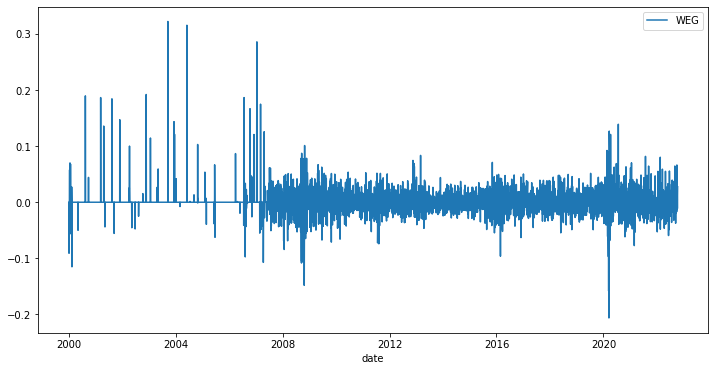

In [169]:
retornos.plot(figsize=(12,6));

**3 - Ausência de autocorrelação**

Autocorrelação dos retornos diários

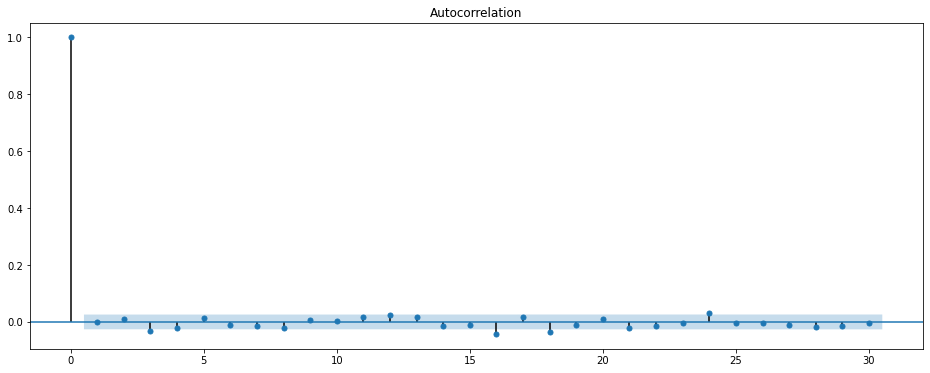

In [170]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos,lags=30, ax=ax)
plt.show()

Retornos em 1 min

In [171]:
acao1m = periodo.history(period='7d',  interval = '1m')
acao1m = acao1m.rename({"close": nome}, axis=1).xs(ticker)
acao1m = acao1m[[nome]]
acao1m

,WEG
date,
2022-10-03 10:03:00,32.959999
2022-10-03 10:15:00,31.930000
2022-10-03 10:16:00,31.639999
2022-10-03 10:17:00,31.650000
2022-10-03 10:18:00,31.549999
...,...
2022-10-11 16:51:00,33.869999
2022-10-11 16:52:00,33.880001
2022-10-11 16:53:00,33.849998


Autocorrelação dos retornos em 1 min

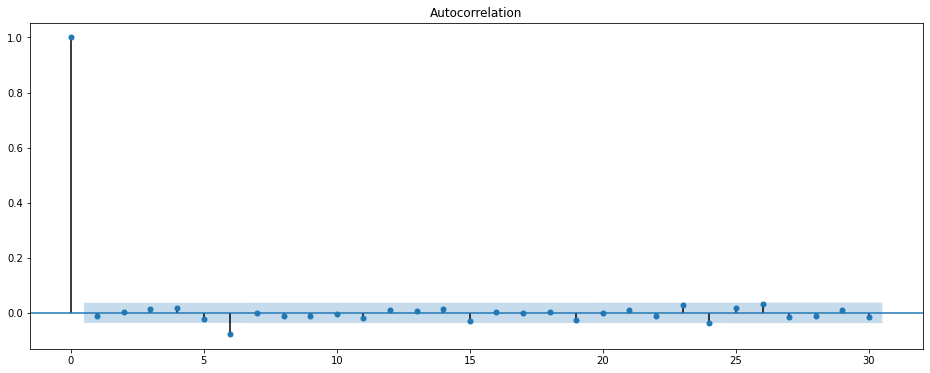

In [172]:
fig, ax = plt.subplots(figsize=(16, 6))
retornos1m = acao1m.pct_change().dropna()
plot_acf(retornos1m,lags=30, ax=ax)
plt.show()

**4 - Decaimento lento da autocorrelação dos quadrados dos retornos**

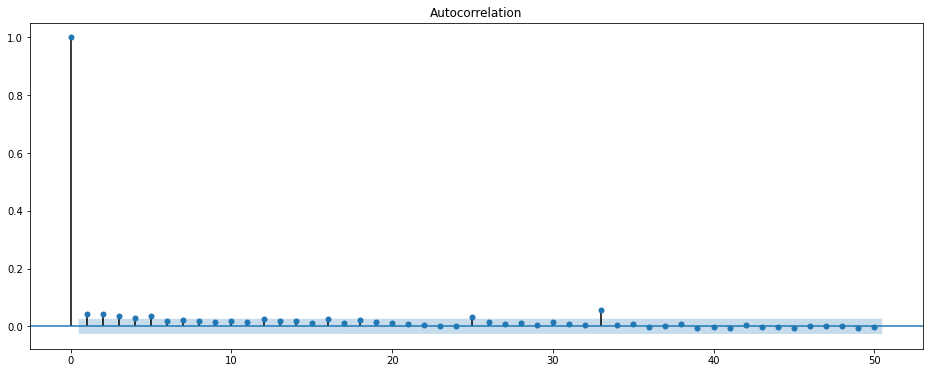

In [173]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos**2,lags=50, alpha=0.05, ax=ax)
plt.show()

É válido também para o módulo dos retornos

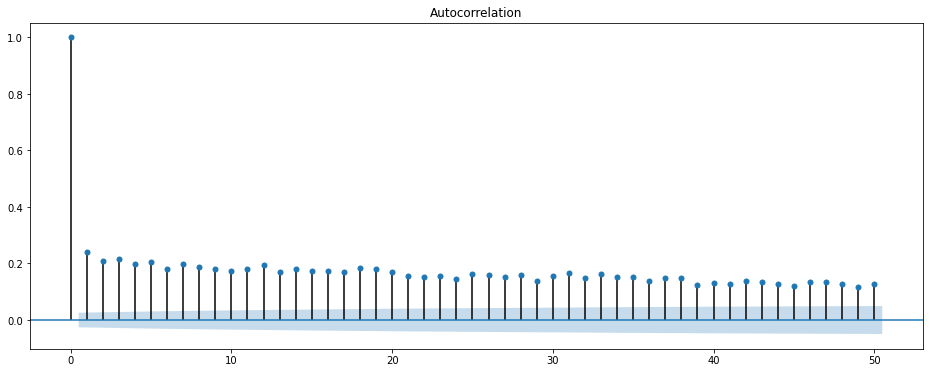

In [174]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(abs(retornos),lags=50, alpha=0.05, ax=ax)
plt.show()

**5 - Efeito de alavancagem**

In [175]:
desv_pad_21d = retornos[nome].rolling(window=21).std()
desv_pad_21d

date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
                ...   
2022-10-04    0.024459
2022-10-05    0.024189
2022-10-06    0.023564
2022-10-07    0.023785
2022-10-10    0.024288
Name: WEG, Length: 5722, dtype: float64

In [176]:
desv_pad_252d = retornos[nome].rolling(window=252).std()

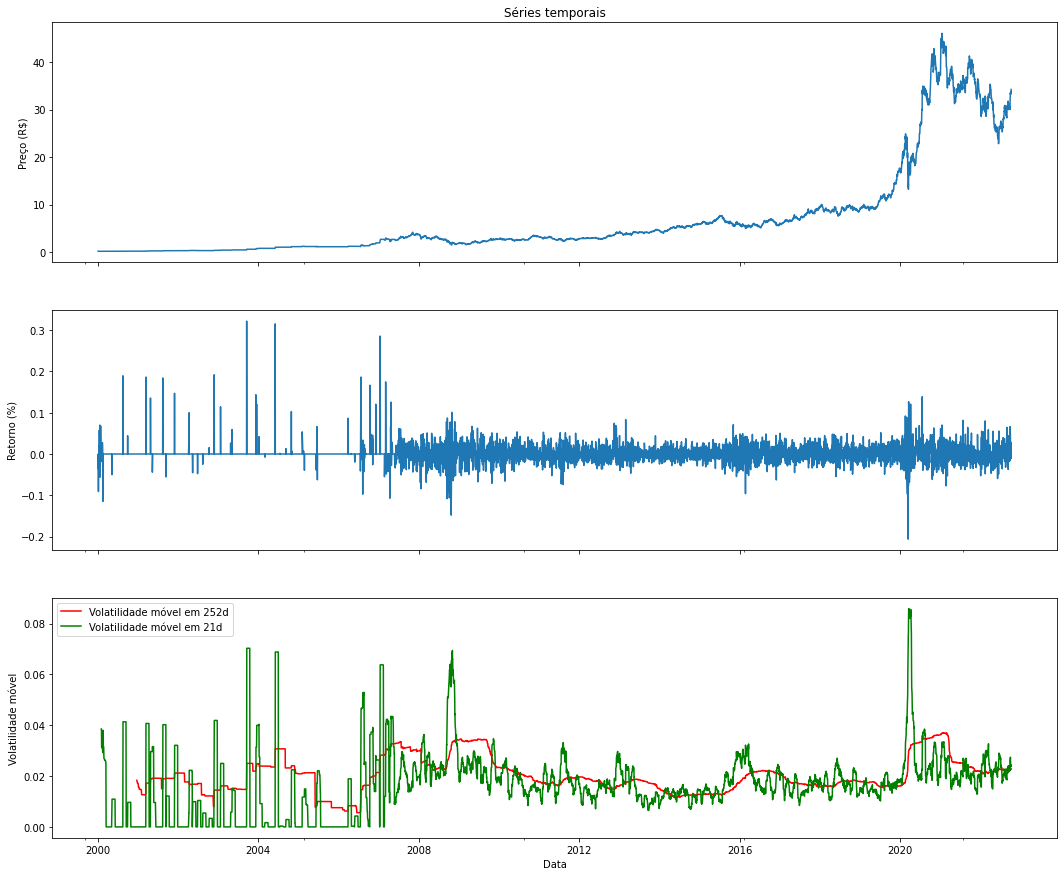

In [177]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
acao[nome].plot(ax=ax[0])
ax[0].set(title='Séries temporais', ylabel='Preço (R$)')
retornos[nome].plot(ax=ax[1])
ax[1].set(ylabel='Retorno (%)')
desv_pad_252d.plot(ax=ax[2], color='r', label='Volatilidade móvel em 252d')
desv_pad_21d.plot(ax=ax[2], color='g', label='Volatilidade móvel em 21d')
ax[2].set(ylabel='Volatilidade móvel', xlabel='Data')
ax[2].legend()
plt.show()

**6 - Gaussianidade agregativa**

In [178]:
# Dataframe com colunas de retornos com lags para serem utilizados no loop
df_retornos_lag = pd.DataFrame(acao[nome])
lags = 6
for lag in range(1, lags+1):
    col = f'Retorno com lag de {lag} dias'
    df_retornos_lag[col] = df_retornos_lag[nome]. \
                         pct_change(periods=lag)
    
df_retornos_lag.replace([np.inf, -np.inf], np.nan, inplace=True)
df_retornos_lag.dropna(inplace=True)
df_retornos_lag.head()

,WEG,Retorno com lag de 1 dias,Retorno com lag de 2 dias,Retorno com lag de 3 dias,Retorno com lag de 4 dias,Retorno com lag de 5 dias,Retorno com lag de 6 dias
date,,,,,,,
2000-01-11,0.147928,0.000000,0.000000,0.000000,-0.090910,-0.090910,-0.122813
2000-01-12,0.150887,0.020003,0.020003,0.020003,0.020003,-0.072726,-0.072726
2000-01-13,0.153846,0.019611,0.040006,0.040006,0.040006,0.040006,-0.054541
2000-01-14,0.162721,0.057688,0.078430,0.100001,0.100001,0.100001,0.100001
2000-01-17,0.156804,-0.036363,0.019227,0.039215,0.060002,0.060002,0.060002


In [179]:
# Extraindo a estatística descritiva de cada coluna utilizando a função describe() do pandas
def extract_data_stats(df_col):
    d_stat = df_col.describe()
    mu = d_stat['mean']
    sigma = d_stat['std']
    rtn_range = np.linspace(d_stat['min'], d_stat['max'], num=1000)
    norm_pdf = scs.norm.pdf(rtn_range, loc=mu, scale=sigma)
    
    return mu, sigma, rtn_range, norm_pdf

# Usa o ax para criar múltiplos gráficos
def draw_hist_mult(df_col, ax=None):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(df_col)
    #sns.distplot(df_col, kde=True, norm_hist=True, label='Hist', ax=ax)
    sns.histplot(df_col, kde=True, stat="density", label='Hist', ax=ax, alpha=.3)
    ax.plot(rtn_range, norm_pdf, 'r', lw=3)
    ax.axvline(x=0, c='c',linestyle='--', lw=3)
    ax.set_xlim((-4*sigma, 4*sigma))
    ax.legend(loc='upper right', fontsize=8, frameon=True,fancybox=True);

# Cria uma figura com os subplots criados pela função draw_hist_mult()
def draw_hist_subplots(df):
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
  fig.subplots_adjust(hspace = .5) #wspace=.001
  fig.suptitle('Distribuição dos retornos em escalas de tempo crescentes', fontsize=18)
  axs = axs.ravel()
  for i in range(len(df.columns)-1):
    draw_hist_mult(df[df.columns[i+1]], ax = axs[i])

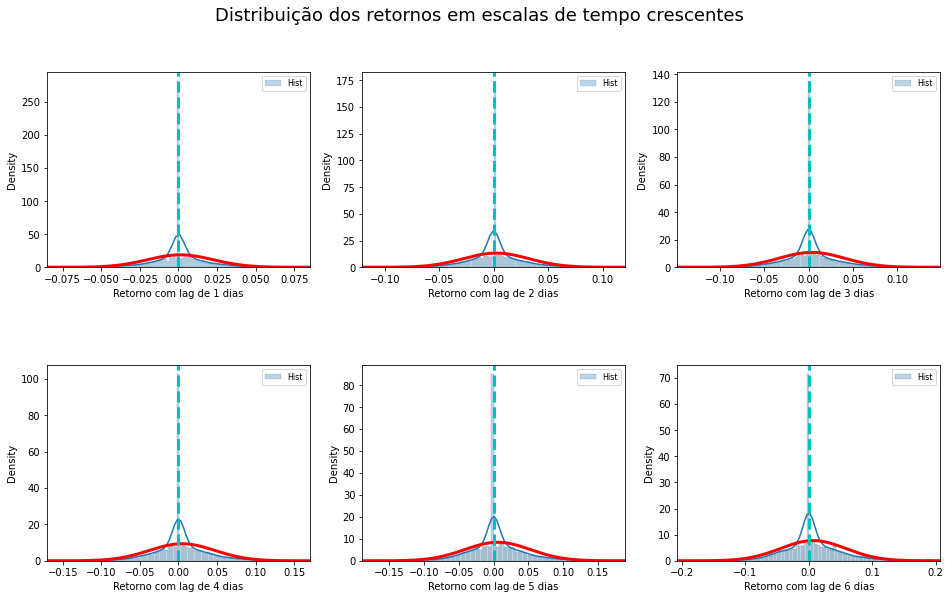

In [180]:
draw_hist_subplots(df_retornos_lag)

É possível verificar uma densidade não tão alta dos retornos e assim fica difícil visualizar a tendência de uma distribuição normal.


## Fatos Estilizados: CVC BRASIL


**1 - Distribuições não Gaussianas**

Identificando o período dos dados totais disponíveis

In [181]:
ticker = 'CVCB3.SA'
nome = 'CVC BRASIL'
periodo = Ticker(ticker)
periodo.history(period='max').reset_index()['date']

0       2013-12-09
1       2013-12-10
2       2013-12-11
3       2013-12-12
4       2013-12-13
           ...    
2191    2022-10-05
2192    2022-10-06
2193    2022-10-07
2194    2022-10-10
2195    2022-10-11
Name: date, Length: 2196, dtype: object

Selecionando o período e coluna de fechamento dos preços. A coluna de fechamento é renomeada para o nome da empresa escolhida

In [182]:
data_inicial = '2013-12-09'
data_final = '2022-10-11'
acao = periodo.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
acao

,CVC BRASIL
date,
2013-12-09,15.55
2013-12-10,15.90
2013-12-11,15.75
2013-12-12,15.50
2013-12-13,15.50
...,...
2022-10-04,6.88
2022-10-05,7.00
2022-10-06,7.14


Calculando a função de densidade de probabilidade normal utilizando a média e o desvio padrão dos retornos observados

In [183]:
retornos = acao.pct_change().dropna()
r_range = np.linspace(retornos.min(), retornos.max(), num=1000)
mu = retornos.mean()
sigma = retornos.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Plotando o histograma e o Q-Q plot

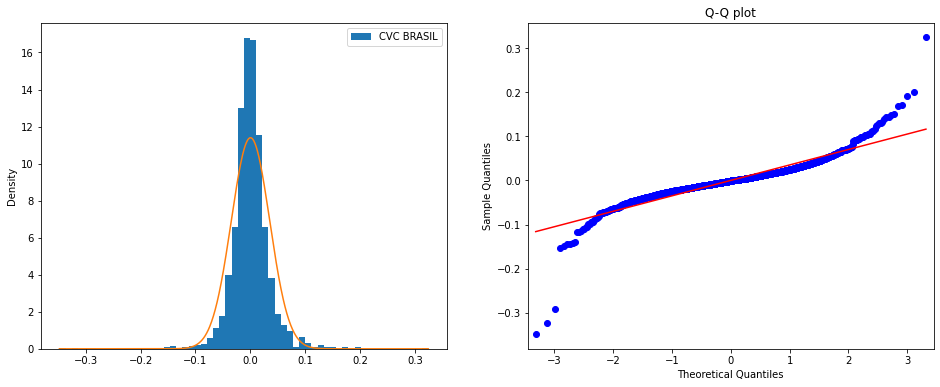

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histograma comparando com uma distribuição normal de mesma média e desvio padrão:
retornos.plot.hist(density=True, bins=60, ax=ax[0], ylabel='Density');
# parâmetros para curva normal
mediaR = retornos.mean()
desvpadR = retornos.std()
minR = retornos.min()
maxR = retornos.max()
x = np.linspace(minR,maxR,1000)
ax[0].plot(x, scs.norm.pdf(x,loc=mediaR,scale=desvpadR))
ax[0].set(ylabel='Density')

# Q-Q plot
qq = sm.qqplot(retornos[nome].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 12)
plt.show()

Teste quantitativo de normalidade de Shapiro-Wilk

In [185]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
shapirowilk = shapiro(retornos)
if shapirowilk[1] <= 0.05:
  print("Hipotese Nula Rejeitada")
else:
  print("Não rejeitar hipotese nula") #minha amostra possui uma distribuição normal

print('O valor-p calculado foi de', shapirowilk[1])

Hipotese Nula Rejeitada
O valor-p calculado foi de 3.53033606272437e-39


Teste quantitativo de normalidade de Jarque-Bera

In [186]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
jarque_bera(retornos)

Jarque_beraResult(statistic=23087.304694241346, pvalue=0.0)

In [187]:
len(retornos)

2194

In [188]:
# Jarque-Bera implementado "na unha"
JB = (len(retornos)/6)*( skew(retornos)**2 + (1/4)*(kurtosis(retornos)**2 ))
JB

array([23087.30469424])

Comparando o teste com dados normalmente distribuídos

In [189]:
norm = np.random.randn(len(retornos))
jarque_bera(norm)

Jarque_beraResult(statistic=1.1214102677841191, pvalue=0.5708064269515876)

**2 - Aglomerados de volatilidade**

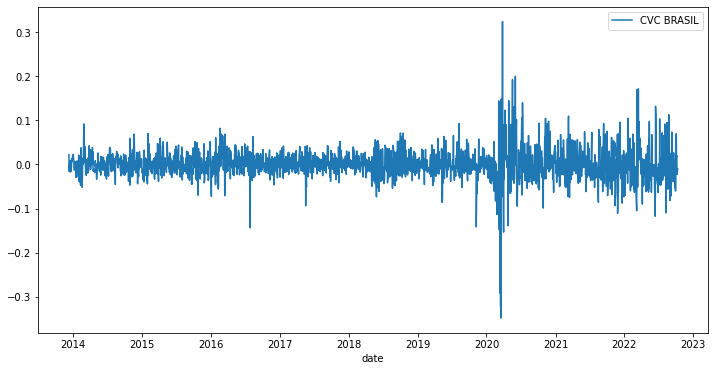

In [190]:
retornos.plot(figsize=(12,6));

**3 - Ausência de autocorrelação**

Autocorrelação dos retornos diários

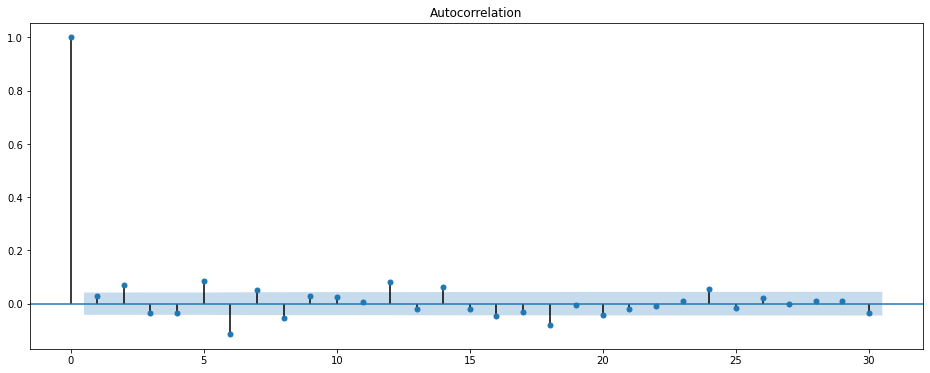

In [191]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos,lags=30, ax=ax)
plt.show()

Retornos em 1 min

In [192]:
acao1m = periodo.history(period='7d',  interval = '1m')
acao1m = acao1m.rename({"close": nome}, axis=1).xs(ticker)
acao1m = acao1m[[nome]]
acao1m

,CVC BRASIL
date,
2022-10-03 10:09:00,6.62
2022-10-03 10:10:00,6.63
2022-10-03 10:11:00,6.66
2022-10-03 10:12:00,6.72
2022-10-03 10:13:00,6.71
...,...
2022-10-11 16:51:00,6.52
2022-10-11 16:52:00,6.52
2022-10-11 16:53:00,6.53


Autocorrelação dos retornos em 1 min

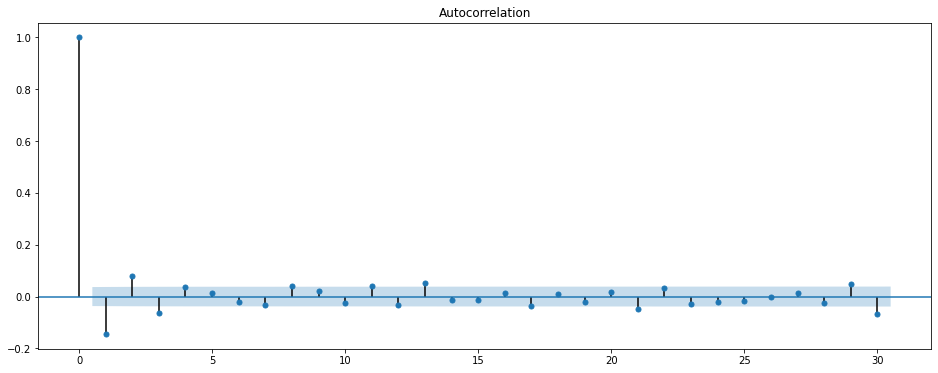

In [193]:
fig, ax = plt.subplots(figsize=(16, 6))
retornos1m = acao1m.pct_change().dropna()
plot_acf(retornos1m,lags=30, ax=ax)
plt.show()

**4 - Decaimento lento da autocorrelação dos quadrados dos retornos**

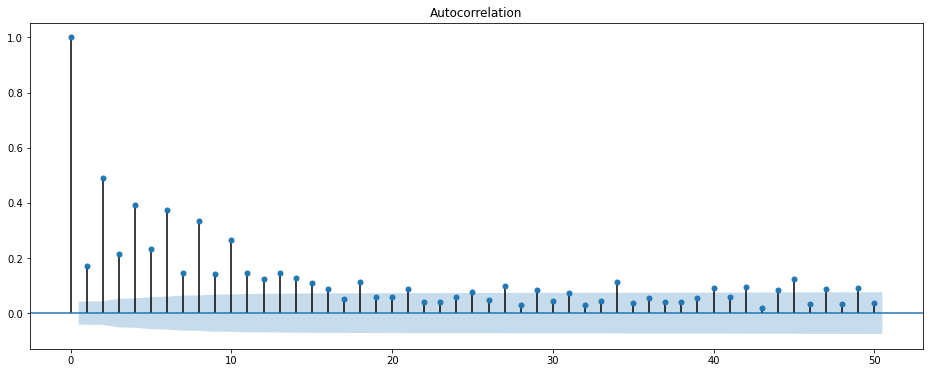

In [194]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos**2,lags=50, alpha=0.05, ax=ax)
plt.show()

É válido também para o módulo dos retornos

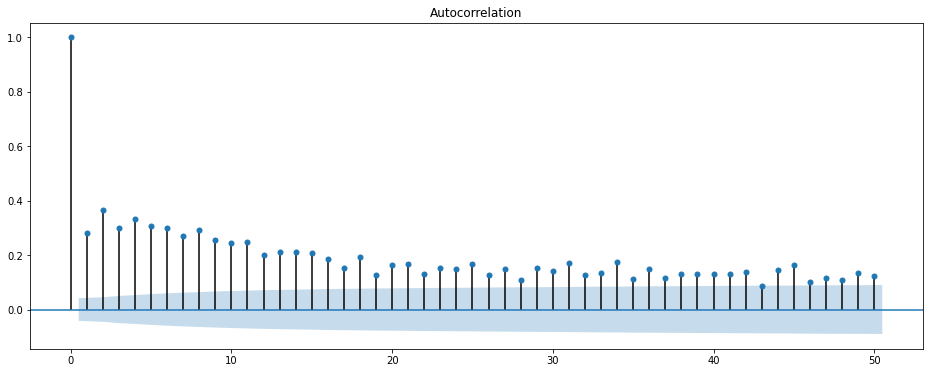

In [195]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(abs(retornos),lags=50, alpha=0.05, ax=ax)
plt.show()

**5 - Efeito de alavancagem**

In [196]:
desv_pad_21d = retornos[nome].rolling(window=21).std()
desv_pad_21d

date
2013-12-10         NaN
2013-12-11         NaN
2013-12-12         NaN
2013-12-13         NaN
2013-12-16         NaN
                ...   
2022-10-04    0.040046
2022-10-05    0.040320
2022-10-06    0.037516
2022-10-07    0.037388
2022-10-10    0.033188
Name: CVC BRASIL, Length: 2194, dtype: float64

In [197]:
desv_pad_252d = retornos[nome].rolling(window=252).std()

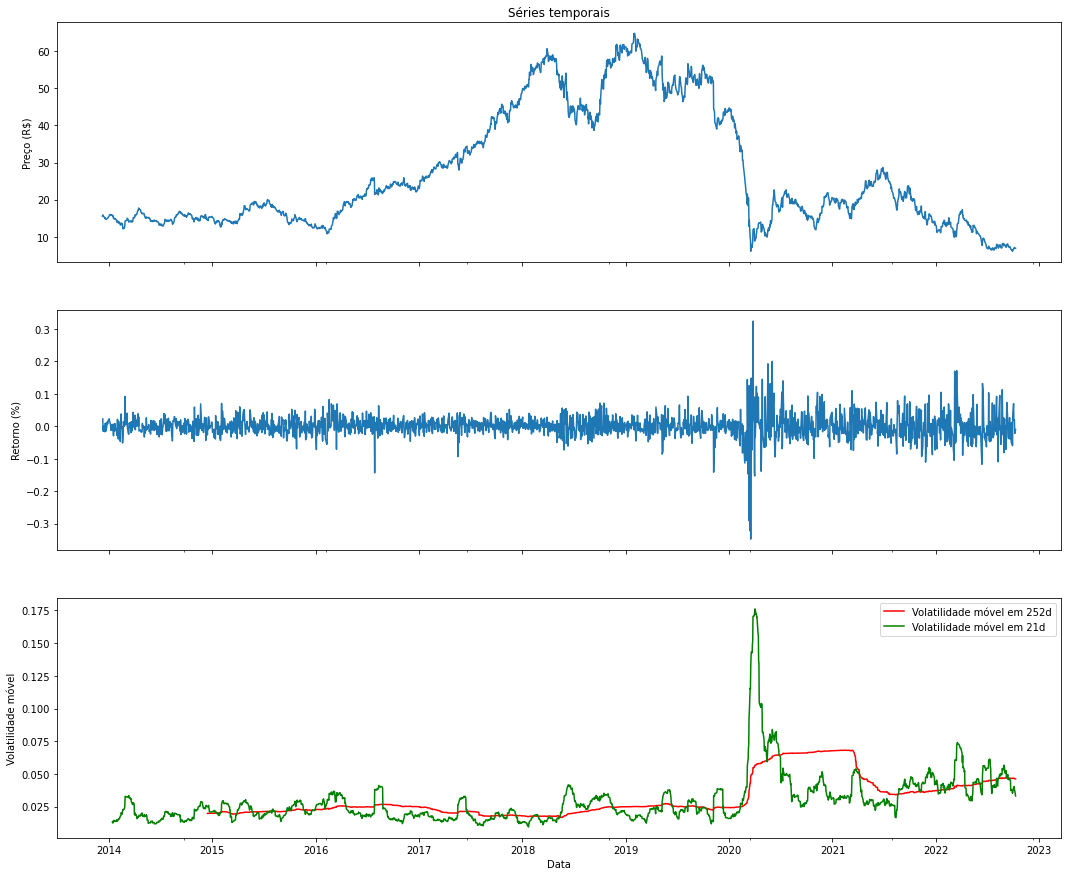

In [198]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
acao[nome].plot(ax=ax[0])
ax[0].set(title='Séries temporais', ylabel='Preço (R$)')
retornos[nome].plot(ax=ax[1])
ax[1].set(ylabel='Retorno (%)')
desv_pad_252d.plot(ax=ax[2], color='r', label='Volatilidade móvel em 252d')
desv_pad_21d.plot(ax=ax[2], color='g', label='Volatilidade móvel em 21d')
ax[2].set(ylabel='Volatilidade móvel', xlabel='Data')
ax[2].legend()
plt.show()

**6 - Gaussianidade agregativa**

In [199]:
# Dataframe com colunas de retornos com lags para serem utilizados no loop
df_retornos_lag = pd.DataFrame(acao[nome])
lags = 6
for lag in range(1, lags+1):
    col = f'Retorno com lag de {lag} dias'
    df_retornos_lag[col] = df_retornos_lag[nome]. \
                         pct_change(periods=lag)
    
df_retornos_lag.replace([np.inf, -np.inf], np.nan, inplace=True)
df_retornos_lag.dropna(inplace=True)
df_retornos_lag.head()

,CVC BRASIL,Retorno com lag de 1 dias,Retorno com lag de 2 dias,Retorno com lag de 3 dias,Retorno com lag de 4 dias,Retorno com lag de 5 dias,Retorno com lag de 6 dias
date,,,,,,,
2013-12-17,15.15,-0.006557,-0.022581,-0.022581,-0.038095,-0.047170,-0.025724
2013-12-18,14.90,-0.016502,-0.022951,-0.038710,-0.038710,-0.053968,-0.062893
2013-12-19,15.04,0.009396,-0.007261,-0.013770,-0.029677,-0.029677,-0.045079
2013-12-20,14.80,-0.015957,-0.006711,-0.023102,-0.029508,-0.045161,-0.045161
2013-12-23,14.70,-0.006757,-0.022606,-0.013423,-0.029703,-0.036066,-0.051613


In [200]:
# Extraindo a estatística descritiva de cada coluna utilizando a função describe() do pandas
def extract_data_stats(df_col):
    d_stat = df_col.describe()
    mu = d_stat['mean']
    sigma = d_stat['std']
    rtn_range = np.linspace(d_stat['min'], d_stat['max'], num=1000)
    norm_pdf = scs.norm.pdf(rtn_range, loc=mu, scale=sigma)
    
    return mu, sigma, rtn_range, norm_pdf

# Usa o ax para criar múltiplos gráficos
def draw_hist_mult(df_col, ax=None):
    mu, sigma, rtn_range, norm_pdf = extract_data_stats(df_col)
    #sns.distplot(df_col, kde=True, norm_hist=True, label='Hist', ax=ax)
    sns.histplot(df_col, kde=True, stat="density", label='Hist', ax=ax, alpha=.3)
    ax.plot(rtn_range, norm_pdf, 'r', lw=3)
    ax.axvline(x=0, c='c',linestyle='--', lw=3)
    ax.set_xlim((-4*sigma, 4*sigma))
    ax.legend(loc='upper right', fontsize=8, frameon=True,fancybox=True);

# Cria uma figura com os subplots criados pela função draw_hist_mult()
def draw_hist_subplots(df):
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
  fig.subplots_adjust(hspace = .5) #wspace=.001
  fig.suptitle('Distribuição dos retornos em escalas de tempo crescentes', fontsize=18)
  axs = axs.ravel()
  for i in range(len(df.columns)-1):
    draw_hist_mult(df[df.columns[i+1]], ax = axs[i])

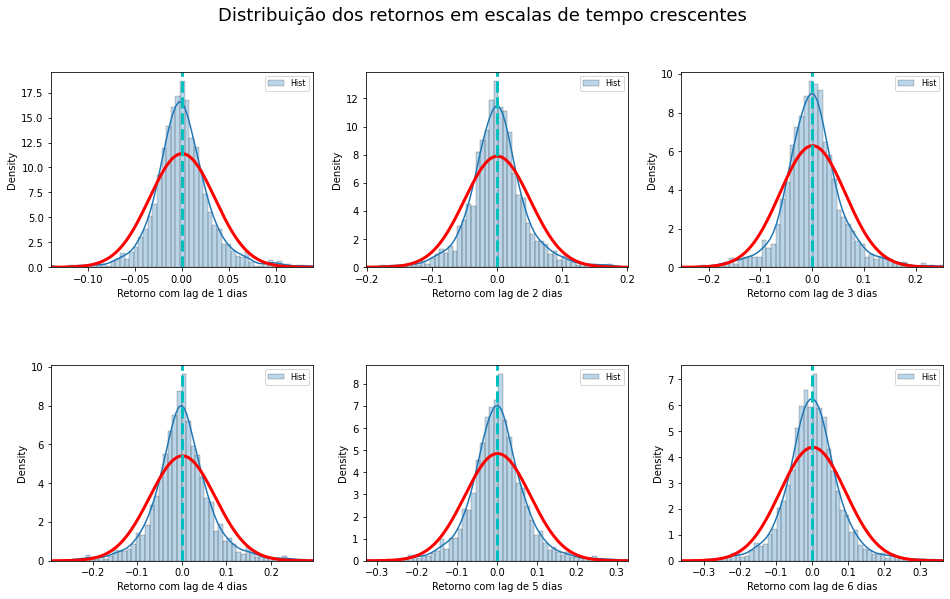

In [201]:
draw_hist_subplots(df_retornos_lag)


É possível verificar que a medida que o intervalo de tempo de cálculo dos retornos aumenta, a distribuição dos retornos tende a uma distribuição normal.


* Selecione as 5 ações de maior peso (consulte a coluna "Part. (%)" das ações que compõem o Ibovespa neste [link](https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm))

* Calcule a correlação de cada ação com o Índice e verifique a hipótese de que a correlação é maior para as ações com maior parte percentual.

* Faça os mesmos passos anteriores para as 5 ações que compõem o índice com menor parte parcentual

## Correlação a ação com 1ª maior parte percentual com o Ibovespa - VALE

Cálculo dos retornos do Índice Bovespa

In [204]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da VALE

In [208]:
ticker = 'VALE3.SA'
nome = 'VALE'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

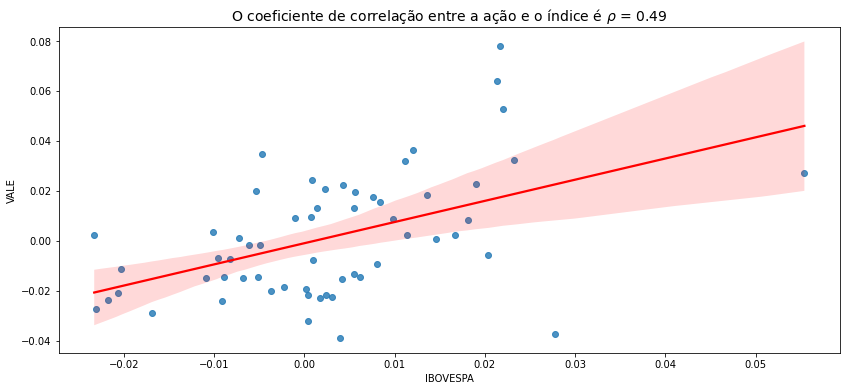

In [209]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

É perceptível que o valor do coeficiente de correlação entre a VALE e o Ibovespa é significante, não chega a 0.6, mas é relativamente alto.

## Correlação a ação com 2ª maior parte percentual com o Ibovespa - PETROBRAS (PETR4)



Cálculo dos retornos do Índice Bovespa

In [210]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da PETROBRAS

In [211]:
ticker = 'PETR4.SA'
nome = 'PETROBRAS'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

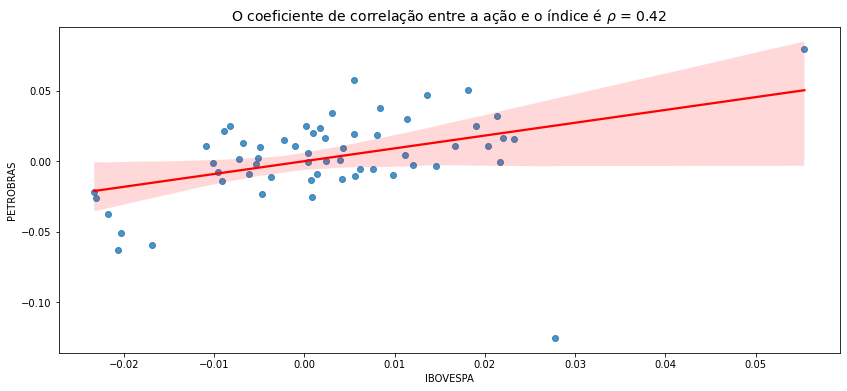

In [212]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

O coeficiente não é tão alto quanto a VALE, mas tem um valor significante.

## Correlação a ação com 3ª maior parte percentual com o Ibovespa - ITAUUNIBANCO



Cálculo dos retornos do Índice Bovespa

In [213]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da ITAUUNIBANCO

In [214]:
ticker = 'ITUB4.SA'
nome = 'ITAUUNIBANCO'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

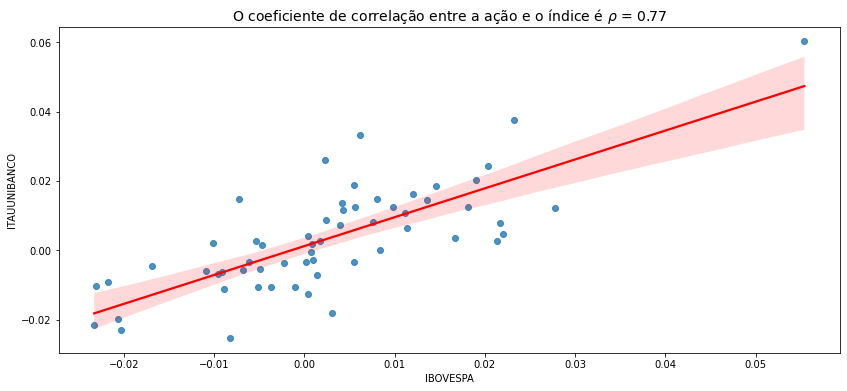

In [215]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Dentre as 3 ações de maior peso, essa é a ação com maior correlação com o Ibovespa.

## Correlação a ação com 4ª maior parte percentual com o Ibovespa - BRADESCO



Cálculo dos retornos do Índice Bovespa

In [219]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação do BRADESCO

In [220]:
ticker = 'BBDC4.SA'
nome = 'BRADESCO'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

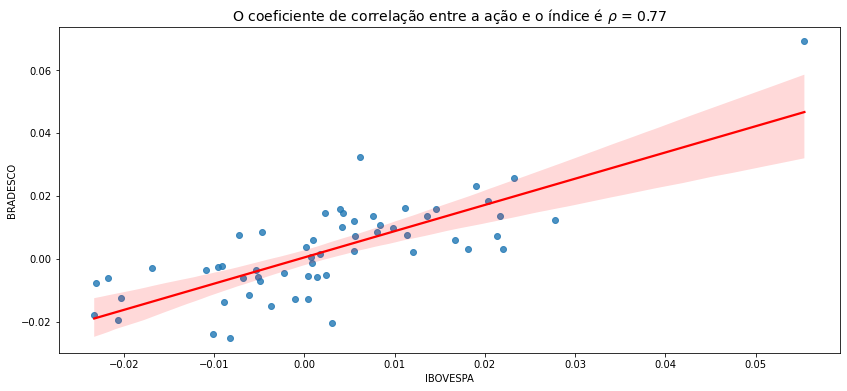

In [221]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Dentre as 4 ações de maior peso, a ação do Bradesco possui o mesmo coeficiente do 3º lugar, assim, tendo um empate, porém, ambas com maior coeficiente dentre o top 4.

## Correlação a ação com 5ª maior parte percentual com o Ibovespa - PETROBRAS (PETR3)



Cálculo dos retornos do Índice Bovespa

In [222]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da PETROBRAS

In [223]:
ticker = 'PETR3.SA'
nome = 'PETROBRAS'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

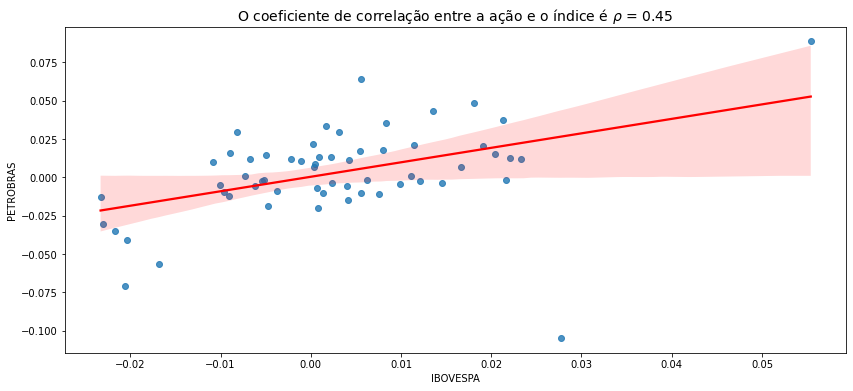

In [224]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Possui um valor baixo, pois geralmente acima de 0.6 é considerado significativo. Porém, o coeficiente de PETR3 > PETR4, embora esteja em quinto lugar no ranking.

## Correlação a ação com 1ª menor parte percentual com o Ibovespa - MELIUZ

Cálculo dos retornos do Índice Bovespa

In [225]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação do MELIUZ

In [226]:
ticker = 'CASH3.SA'
nome = 'MELIUZ'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

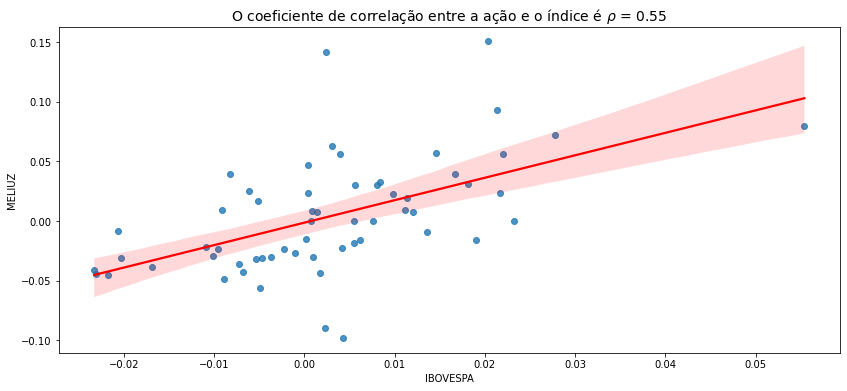

In [227]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

O valor é quase o que se considera suficiente, mas ainda sim, é baixo, pois < 0.6. Porém, já é maior que muitos do top 5 de maiores peso.

## Correlação a ação com 2ª menor parte percentual com o Ibovespa - POSITIVO

Cálculo dos retornos do Índice Bovespa

In [228]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da POSITIVO

In [229]:
ticker = 'POSI3.SA'
nome = 'POSITIVO'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

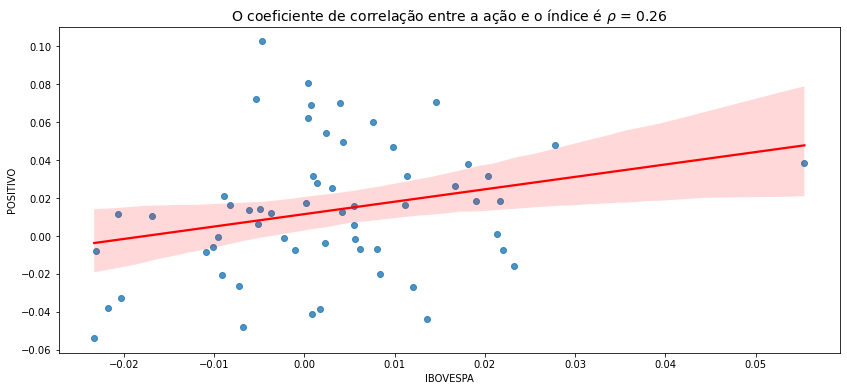

In [230]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Dentre todos os valores observados até o momento, desde o top 5 maiores, até o top 2 menores, esse é o valor mais baixo do coeficiente de correlação.

## Correlação a ação com 3ª menor parte percentual com o Ibovespa - ECORODOVIAS



Cálculo dos retornos do Índice Bovespa

In [231]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da ECORODOVIAS

In [232]:
ticker = 'ECOR3.SA'
nome = 'ECORODOVIAS'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

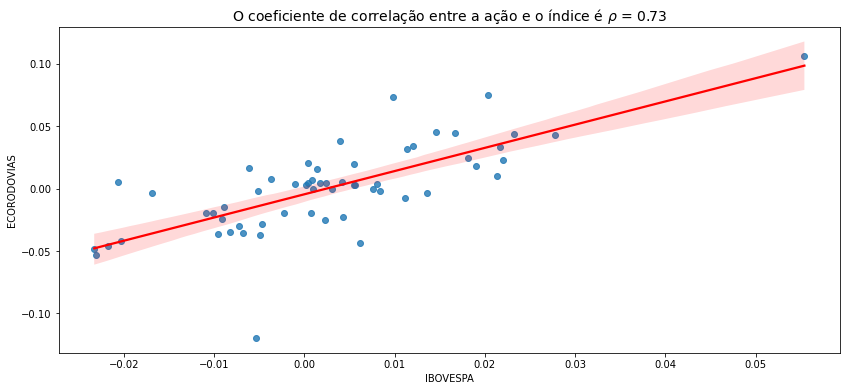

In [233]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Das ações de menor peso em relação ao Ibovespa, essa é a ação com maior coeficiente de correlação, sendo este valor > 0.6. Portanto, pode-se afirmar que há uma correlação significativa.

## Correlação a ação com 4ª menor parte percentual com o Ibovespa - CVC BRASIL



Cálculo dos retornos do Índice Bovespa

In [234]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da CVC BRASIL

In [235]:
ticker = 'CVCB3.SA'
nome = 'CVC BRASIL'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

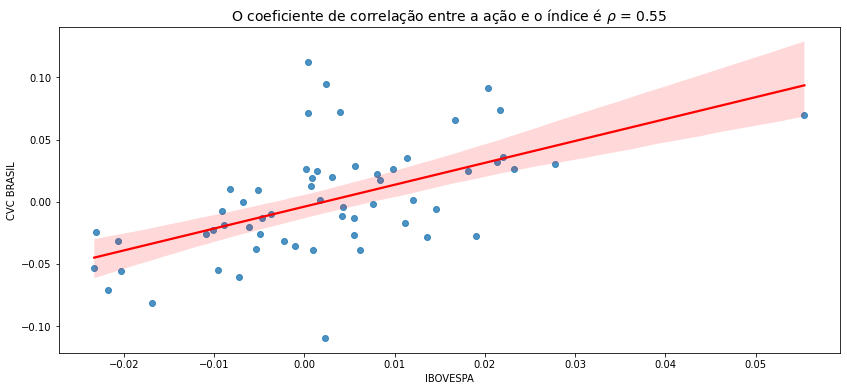

In [236]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

O valor é quase o que se considera suficiente, mas ainda sim, é baixo, pois < 0.6. É o mesmo valor que o primeiro lugar das ações de menor peso no Ibovespa.

## Correlação a ação com 5ª menor parte percentual com o Ibovespa - GOL



Cálculo dos retornos do Índice Bovespa

In [237]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
retornos_ibov = ibov.pct_change().dropna()

Cálculo dos retornos da ação da GOL

In [238]:
ticker = 'GOLL4.SA'
nome = 'GOL'
periodo = Ticker(ticker)
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
retornos = acao.pct_change().dropna()

Concatena os dataframes de retorno e calculo o coeficiente de correlação dos retornos bem como a reta de regressão que melhor se ajusta aos dados

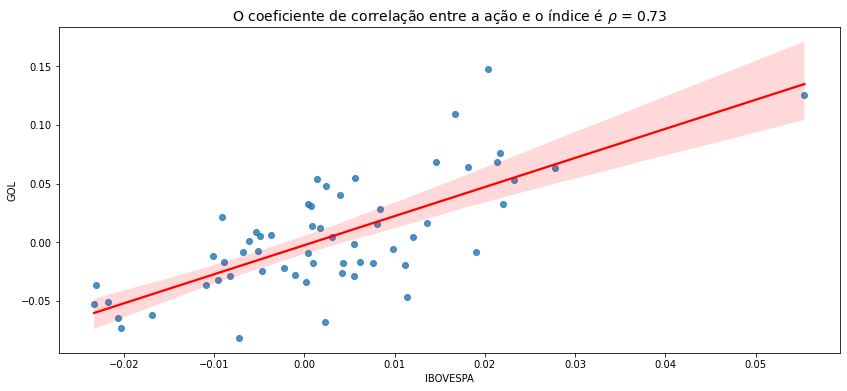

In [239]:
df = pd.concat([retornos,retornos_ibov], axis=1)
fig, ax = plt.subplots(figsize=(14, 6), sharex=True)
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
ax.set_title(f'O coeficiente de correlação entre a ação e o índice é $\\rho$ = {corr_coeff:.2f}', fontsize=14)
plt.show()

Possui um valor de coeficiente de correlação considerável, já que 0.73 > 0.6. Empatando com o 3º lugar do ranking.